In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def trend(time, slope=0):
    return slope* time


In [3]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 *np.pi),
                    1/np.exp(5* season_time))

In [4]:
def seasonality(time, period, amplitude =1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


In [5]:
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [6]:
def plot_series (time, series, format='-', start = 0, end = None, label = None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [8]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += white_noise(time, noise_level, seed=42)

In [9]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

In [12]:
model.fit(dataset,epochs=100,verbose=0)


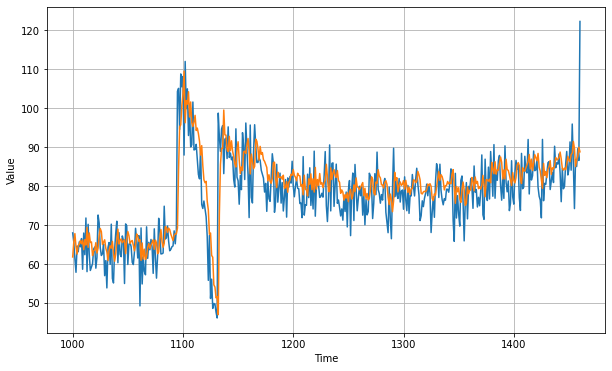

In [13]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.36153

In [15]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)

In [16]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)


(1e-08, 0.001, 0.0, 300.0)

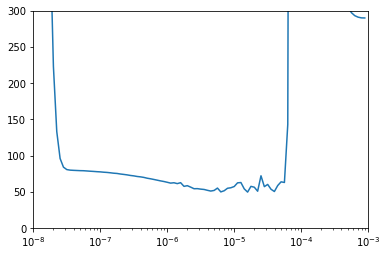

In [17]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [23]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)


In [24]:
history = model.fit(dataset, epochs=500, verbose=0)

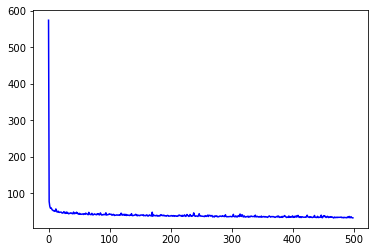

In [25]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[50.83830642700195, 51.1807746887207, 57.42894744873047, 53.48866271972656, 48.81670379638672, 49.18777084350586, 51.13056564331055, 48.394840240478516, 47.912742614746094, 48.60005569458008, 48.59673309326172, 48.6182746887207, 46.318878173828125, 46.13042449951172, 46.616111755371094, 49.878326416015625, 48.79891586303711, 45.324737548828125, 45.46337127685547, 48.854400634765625, 45.77881622314453, 48.11800765991211, 45.560211181640625, 44.093650817871094, 45.267539978027344, 45.09764099121094, 46.505577087402344, 46.66534423828125, 44.96458053588867, 45.058231353759766, 43.943599700927734, 48.88859176635742, 45.01957321166992, 44.496673583984375, 46.26411056518555, 46.16132736206055, 48.50938034057617, 44.943355560302734, 45.75316619873047, 43.10747528076172, 43.107200622558594, 45.344730377197266, 42.74592208862305, 42.97257614135742, 42.73417282104492, 43.56251907348633, 43.5641975402832, 42.25556564331055, 43.928043365478516, 43.57315444946289, 42.737579345703125, 45.88976669311

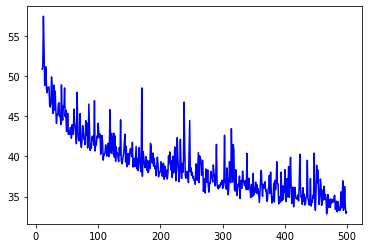

In [26]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

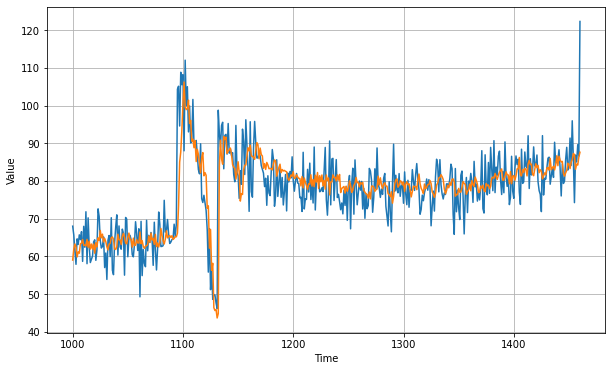

In [27]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


4.796833